## UKT studies

In [10]:
import pandas as pd
import numpy as np
import scipy as sp
from skbio.stats import subsample_counts
from biom import load_table
from gneiss.cluster import correlation_linkage
from gneiss.util import rename_internal_nodes, match
from gneiss.balances import balance_basis
from skbio.stats.composition import ilr
import skbio
import qiime2

import dsfdr
import statistics
import transform

%matplotlib notebook
import matplotlib.pyplot as plt
import pylab

In [4]:
def convert_biom_to_pandas(table):
    otu_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    return otu_table

In [5]:
table = load_table('../data/uk_twins_otu.biom')
otu_table = convert_biom_to_pandas(table)

In [6]:
otu_table.shape

(1024, 8480)

In [13]:
# rarefy
otu_table2 = np.array(otu_table).astype(int)
otu_sum = np.sum(otu_table2, axis=1)
sp.stats.describe(otu_sum)

DescribeResult(nobs=1024, minmax=(1, 221590), mean=67951.91015625, variance=433539807.02417827, skewness=1.3979147276026986, kurtosis=8.172578670623487)

In [21]:
labels = np.array(otu_sum >= 10000) # minmax = (1k, 10k)
otu_table3 = otu_table2[labels==True, :]
otu_table3.shape

(1017, 8480)

In [22]:
otu_table_r = np.zeros(np.shape(otu_table3))
for i in range(np.shape(otu_table3)[0]):
    col_r = subsample_counts(otu_table3[i, :], 10000)
    otu_table_r[i, :] = col_r

In [23]:
# generate the tree
otu_table_r = pd.DataFrame(otu_table_r)
otu_tree = correlation_linkage(otu_table_r + 1)

basis, _ = balance_basis(otu_tree)
balances = ilr(otu_table + 1, basis)

In [24]:
balance_ids = [n.name for n in otu_tree.levelorder() if not n.is_tip()]
balances_df = pd.DataFrame(balances, index=otu_table.index, columns=balance_ids)

In [25]:
mapping = pd.read_table("../data/uk_twins_map.txt", sep='\t', header=0, index_col=0)

In [26]:
mapping['bmi_cat'].value_counts()

Lean     294
Obese    117
Name: bmi_cat, dtype: int64

In [27]:
mapping, balances_df = match(mapping, balances_df)

In [28]:
# fix floating point error in balances output
balances_df = np.array(balances_df)
for col in range(np.shape(balances_df)[1]):
    for row in range(np.shape(balances_df)[0]):
        close = np.isclose(balances_df[row, col], balances_df[:, col])
        balances_df[close, col] = balances_df[row, col] 

In [29]:
balances_ukt = np.transpose(balances_df)
labels_ukt = np.array((mapping['bmi_cat'] == 'Lean').astype(int))

In [30]:
print(balances_ukt.shape)
print(labels_ukt.shape)

(8479, 390)
(390,)


In [45]:
results1 = dsfdr.dsfdr(data = balances_ukt, labels = labels_ukt, fdr_method='dsfdr')
results2 = dsfdr.dsfdr(data = balances_ukt, labels = labels_ukt, fdr_method='bhfdr')

In [46]:
ds = np.sum(results1[0])
bh = np.sum(results2[0])
print(ds, bh, ds-bh, (ds-bh)/bh*100)

582 450 132 29.3333333333


In [47]:
pvals = results1[2]

2148.99040705


<IPython.core.display.Javascript object>


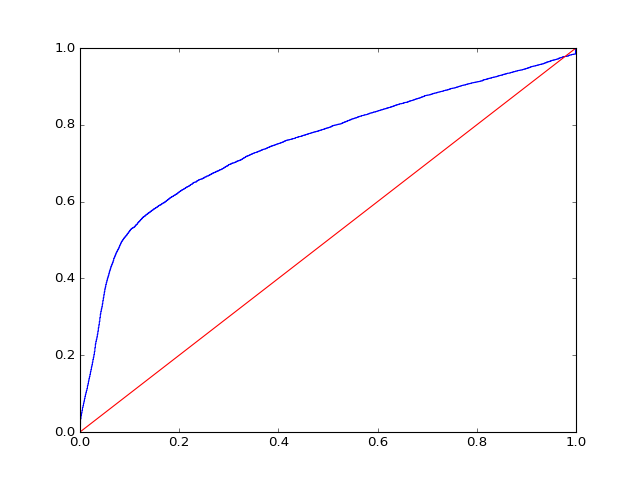

In [48]:
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import linalg as LA

sample = pvals
ecdf = ECDF(sample)

x = np.sort(sample)
y = ecdf(x)
print(LA.norm(x - y, 1))

plt.figure()
plt.step(x, y)
plt.plot(x, x, color = 'red')